In [10]:
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [152]:
import helpers.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [4]:
dataset = PennFudanDataset('PennFudanPed', get_transform(train=False))

In [153]:
import helpers.utils as utls
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True,
 collate_fn=utls.collate_fn)
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = list(target for target in targets)
img = images[0]
trgt = targets[0]

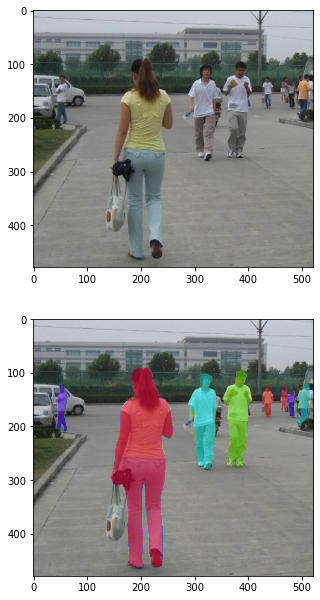

In [150]:
import torchvision

trans_img = torchvision.transforms.ToPILImage()

# set up the Axes objects

fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(9.6, 10.4))

# plot using 'continuous' colormap
im = ax0.imshow(trans_img(img))
im = ax1.imshow(trans_img(img))


masks = torch.zeros_like(img[0])
for i,mask in enumerate(trgt["masks"]):
    masks += mask *50 *(i+1)


im = ax1.imshow(trans_img(masks),alpha = 0.5* masks.type(torch.bool).type(torch.float).numpy(),cmap=plt.get_cmap('hsv'))


plt.show()

In [124]:

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [151]:
from helpers.engine import train_one_epoch, evaluate



def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 5 epochs
    num_epochs = 5

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")


In [42]:
if __name__ == "__main__":
    main()

Epoch: [0]  [ 0/60]  eta: 0:24:37  lr: 0.000090  loss: 3.2536 (3.2536)  loss_classifier: 0.8473 (0.8473)  loss_box_reg: 0.3451 (0.3451)  loss_mask: 2.0158 (2.0158)  loss_objectness: 0.0430 (0.0430)  loss_rpn_box_reg: 0.0024 (0.0024)  time: 24.6314  data: 0.0856
Epoch: [0]  [10/60]  eta: 0:21:36  lr: 0.000936  loss: 1.4843 (1.9050)  loss_classifier: 0.5440 (0.5361)  loss_box_reg: 0.2697 (0.2862)  loss_mask: 0.7546 (1.0482)  loss_objectness: 0.0242 (0.0286)  loss_rpn_box_reg: 0.0052 (0.0058)  time: 25.9378  data: 0.0996
Epoch: [0]  [20/60]  eta: 0:16:01  lr: 0.001783  loss: 0.9433 (1.3313)  loss_classifier: 0.2026 (0.3543)  loss_box_reg: 0.2603 (0.2761)  loss_mask: 0.3214 (0.6727)  loss_objectness: 0.0177 (0.0227)  loss_rpn_box_reg: 0.0052 (0.0055)  time: 24.0144  data: 0.0926
Epoch: [0]  [30/60]  eta: 0:25:33  lr: 0.002629  loss: 0.6008 (1.0843)  loss_classifier: 0.0982 (0.2720)  loss_box_reg: 0.2011 (0.2738)  loss_mask: 0.2235 (0.5140)  loss_objectness: 0.0074 (0.0185)  loss_rpn_box_re

Epoch: [2]  [ 0/60]  eta: 0:23:12  lr: 0.005000  loss: 0.1843 (0.1843)  loss_classifier: 0.0225 (0.0225)  loss_box_reg: 0.0360 (0.0360)  loss_mask: 0.1236 (0.1236)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0019 (0.0019)  time: 23.2115  data: 0.0666
Epoch: [2]  [10/60]  eta: 0:21:45  lr: 0.005000  loss: 0.2239 (0.2369)  loss_classifier: 0.0243 (0.0314)  loss_box_reg: 0.0639 (0.0726)  loss_mask: 0.1305 (0.1268)  loss_objectness: 0.0004 (0.0011)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 26.1081  data: 0.0820
Epoch: [2]  [20/60]  eta: 0:28:53  lr: 0.005000  loss: 0.2222 (0.2286)  loss_classifier: 0.0210 (0.0297)  loss_box_reg: 0.0611 (0.0649)  loss_mask: 0.1305 (0.1282)  loss_objectness: 0.0005 (0.0016)  loss_rpn_box_reg: 0.0030 (0.0042)  time: 44.3450  data: 0.0792
Epoch: [2]  [30/60]  eta: 10:13:59  lr: 0.005000  loss: 0.2222 (0.2314)  loss_classifier: 0.0262 (0.0301)  loss_box_reg: 0.0633 (0.0681)  loss_mask: 0.1216 (0.1277)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_r

Epoch: [4]  [ 0/60]  eta: 0:17:14  lr: 0.000500  loss: 0.1219 (0.1219)  loss_classifier: 0.0111 (0.0111)  loss_box_reg: 0.0118 (0.0118)  loss_mask: 0.0976 (0.0976)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 17.2488  data: 0.0177
Epoch: [4]  [10/60]  eta: 0:19:52  lr: 0.000500  loss: 0.1919 (0.1958)  loss_classifier: 0.0256 (0.0287)  loss_box_reg: 0.0318 (0.0406)  loss_mask: 0.1214 (0.1220)  loss_objectness: 0.0011 (0.0013)  loss_rpn_box_reg: 0.0026 (0.0032)  time: 23.8451  data: 0.0761
Epoch: [4]  [20/60]  eta: 0:16:29  lr: 0.000500  loss: 0.1803 (0.1971)  loss_classifier: 0.0235 (0.0266)  loss_box_reg: 0.0318 (0.0406)  loss_mask: 0.1191 (0.1257)  loss_objectness: 0.0006 (0.0010)  loss_rpn_box_reg: 0.0024 (0.0032)  time: 25.1054  data: 0.0892
Epoch: [4]  [30/60]  eta: 0:12:14  lr: 0.000500  loss: 0.1796 (0.1948)  loss_classifier: 0.0240 (0.0273)  loss_box_reg: 0.0412 (0.0420)  loss_mask: 0.1117 (0.1211)  loss_objectness: 0.0006 (0.0011)  loss_rpn_box_re